In [1]:
!pip install --upgrade pip
!pip install torch torchvision torchaudio 
!pip install timm
!pip install optuna scikit-learn matplotlib seaborn tqdm albumentations


In [ ]:
# imports básicos e configuração de seed para reprodutibilidade
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm  # biblioteca com EfficientNet
import optuna  # busca de hiperparâmetros
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# --- REPRODUTIBILIDADE ---
SEED = 42 
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = False

# --- Paths do dataset ---
TRAIN_DIR = "small-aid/training"
TEST_DIR  = "small-aid/test"

# --- dispositivo ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


/home/queimadas/Desktop/mestrado/deep_learning/EfficientNet/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


In [3]:
# parâmetros comuns para normalização (valores RGB de ImageNet)
IMAGENET_MEAN = [0.485, 0.456, 0.406] #R G B
IMAGENET_STD  = [0.229, 0.224, 0.225] #R G B

# tamanho de entrada recomendado para EfficientNet-B3 ~ 300, B0 ~224, B4 ~380
IMG_SIZE = 300

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),   # recorta e redimensiona de forma aleatória
    transforms.RandomHorizontalFlip(p=0.5),  # flip horizontal aleatório
    transforms.RandomVerticalFlip(p=0.2),    # flip vertical com menor probabilidade
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),                   # converte PIL->Tensor
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)  # normaliza como ImageNet
])

test_transform = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.1)),  # redimensiona mantendo razão
    transforms.CenterCrop(IMG_SIZE),        # crop central
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])


In [4]:
from torchvision.datasets import ImageFolder

# cria datasets
train_dataset = ImageFolder(TRAIN_DIR, transform=train_transform)
test_dataset  = ImageFolder(TEST_DIR, transform=test_transform)

# número de classes
num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)
print("Número de classes:", num_classes)
print("Tamanho train:", len(train_dataset), "tamanho test:", len(test_dataset))

# DataLoader: batch_size, shuffle (apenas treino), num_workers -> ajuste conforme sua máquina
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


Classes: ['Airport', 'BareLand', 'BaseballField', 'Beach', 'Bridge', 'Center', 'Church', 'Commercial', 'DenseResidential', 'Desert', 'Farmland', 'Forest', 'Industrial', 'Meadow', 'MediumResidential', 'Mountain', 'Park', 'Parking', 'Playground', 'Pond', 'Port', 'RailwayStation', 'Resort', 'River', 'School', 'SparseResidential', 'Square', 'Stadium', 'StorageTanks', 'Viaduct']
Número de classes: 30
Tamanho train: 3600 tamanho test: 2400


In [5]:
# Função que cria o modelo EfficientNet com cabeçalho adaptado ao número de classes.
def create_model(model_name="tf_efficientnet_b3", num_classes=num_classes, pretrained=True):
    """
    model_name: string para timm.create_model, ex: "tf_efficientnet_b3", "efficientnet_b0", "tf_efficientnet_b4"
    num_classes: número de saídas desejadas
    pretrained: usar pesos ImageNet
    """
    model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)

    # congela todas as camadas
    for param in model.parameters():
        param.requires_grad = False
    
    # libera somente o classificador final (última camada)
    if hasattr(model, 'classifier'):  # modelos timm costumam ter 'classifier'
        for param in model.classifier.parameters():
            param.requires_grad = True
    elif hasattr(model, 'head'):  # alguns modelos usam 'head'
        for param in model.head.parameters():
            param.requires_grad = True
    
    return model

model = create_model("tf_efficientnet_b3", num_classes=num_classes, pretrained=True).to(device)
print(model)


EfficientNet(
  (conv_stem): Conv2dSame(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNormAct2d(
          40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNo

In [6]:
# função para um epoch de treino
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()  # coloca em modo treino
    running_loss = 0.0
    correct = 0
    total = 0
    for images, targets in tqdm(loader, desc="Train", leave=False):
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()               # zera gradientes
        outputs = model(images)             # forward
        loss = criterion(outputs, targets)  # calcula perda
        loss.backward()                     # backprop
        optimizer.step()                    # step do otimizador

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# função para avaliação
def evaluate(model, loader, criterion, device):
    model.eval()  # modo avaliação (desliga dropout, batchnorm em modo estatico)
    running_loss = 0.0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for images, targets in tqdm(loader, desc="Eval", leave=False):
            images, targets = images.to(device), targets.to(device)

            outputs = model(images)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = (all_preds == all_targets).mean()
    return epoch_loss, epoch_acc, all_preds, all_targets


In [7]:
# rotina para treinar por N épocas (usada pelo optuna e também fora)
def run_training(model, train_loader, val_loader, device, lr=1e-4, weight_decay=1e-4, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, # otimizador
        mode='min', # monitora uma métrica que deve diminuir
        factor=0.5, # multiplica o LR pelo factor quando nao melhora
        patience=2
        )

    best_val_f1 = 0.0
    best_state = None
    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}
    
    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_preds, val_targets = evaluate(model, val_loader, criterion, device)

        # calcula f1-macro
        val_f1 = f1_score(val_targets, val_preds, average='macro') #average macro por ser um dataset balanceado

        print(f"Epoch {epoch+1}/{epochs} | train_loss={train_loss:.4f} train_acc={train_acc:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f} val_f1={val_f1:.4f}")

        scheduler.step(val_loss)  # ajusta lr com base em val_loss

        # salvar melhor modelo em memória
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    # carrega melhor estado encontrado
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_val_f1


[I 2025-11-14 16:03:11,473] A new study created in memory with name: no-name-352a5a95-e2f7-46c9-b496-bbf870f2a7b6
/tmp/ipykernel_2923066/3089791855.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
/tmp/ipykernel_2923066/3089791855.py:58: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)


Epoch 1/10 | train_loss=3.4448 | val_loss=3.2801 | val_f1=0.0863


Epoch 2/10 | train_loss=3.0280 | val_loss=2.9251 | val_f1=0.1876


Epoch 3/10 | train_loss=2.7097 | val_loss=2.6603 | val_f1=0.2985


Epoch 4/10 | train_loss=2.4249 | val_loss=2.4226 | val_f1=0.3467


Epoch 5/10 | train_loss=2.2341 | val_loss=2.2362 | val_f1=0.3881


Epoch 6/10 | train_loss=2.0738 | val_loss=2.0442 | val_f1=0.4403


Epoch 7/10 | train_loss=1.9120 | val_loss=1.9225 | val_f1=0.4866


Epoch 8/10 | train_loss=1.7502 | val_loss=1.8606 | val_f1=0.4916


Epoch 9/10 | train_loss=1.6849 | val_loss=1.7616 | val_f1=0.5341


[I 2025-11-14 16:05:38,354] Trial 0 finished with value: 0.5663263287564037 and parameters: {'model_name': 'tf_efficientnet_b3', 'lr': 0.00015751320499779721, 'weight_decay': 2.9380279387035354e-06}. Best is trial 0 with value: 0.5663263287564037.
/tmp/ipykernel_2923066/3089791855.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
/tmp/ipykernel_2923066/3089791855.py:58: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)


Epoch 10/10 | train_loss=1.5819 | val_loss=1.6470 | val_f1=0.5663


Epoch 1/10 | train_loss=3.4957 | val_loss=3.2812 | val_f1=0.1091


Epoch 2/10 | train_loss=3.0428 | val_loss=2.8758 | val_f1=0.2035


Epoch 3/10 | train_loss=2.6718 | val_loss=2.6035 | val_f1=0.2973


Epoch 4/10 | train_loss=2.3899 | val_loss=2.3862 | val_f1=0.3618


Epoch 5/10 | train_loss=2.1897 | val_loss=2.1720 | val_f1=0.4055


Epoch 6/10 | train_loss=2.0194 | val_loss=2.0448 | val_f1=0.4465


Epoch 7/10 | train_loss=1.8636 | val_loss=1.9238 | val_f1=0.4799


Epoch 8/10 | train_loss=1.7556 | val_loss=1.7958 | val_f1=0.4972


Epoch 9/10 | train_loss=1.6333 | val_loss=1.6815 | val_f1=0.5535


[I 2025-11-14 16:08:10,246] Trial 1 finished with value: 0.5803539346150821 and parameters: {'model_name': 'tf_efficientnet_b4', 'lr': 0.00015930522616241006, 'weight_decay': 0.000133112160807369}. Best is trial 1 with value: 0.5803539346150821.
/tmp/ipykernel_2923066/3089791855.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
/tmp/ipykernel_2923066/3089791855.py:58: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)


Epoch 10/10 | train_loss=1.5624 | val_loss=1.6532 | val_f1=0.5804


Epoch 1/10 | train_loss=3.7090 | val_loss=3.6446 | val_f1=0.0468


Epoch 2/10 | train_loss=3.6208 | val_loss=3.5444 | val_f1=0.0466


Epoch 3/10 | train_loss=3.5203 | val_loss=3.4473 | val_f1=0.0746


Epoch 4/10 | train_loss=3.4242 | val_loss=3.4183 | val_f1=0.0798


Epoch 5/10 | train_loss=3.3513 | val_loss=3.3229 | val_f1=0.0808


Epoch 6/10 | train_loss=3.2760 | val_loss=3.2923 | val_f1=0.0891


Epoch 7/10 | train_loss=3.2056 | val_loss=3.2433 | val_f1=0.1048


Epoch 8/10 | train_loss=3.1555 | val_loss=3.1312 | val_f1=0.1205


Epoch 9/10 | train_loss=3.0709 | val_loss=3.0738 | val_f1=0.1327


[I 2025-11-14 16:10:35,493] Trial 2 finished with value: 0.14867071077033958 and parameters: {'model_name': 'tf_efficientnet_b3', 'lr': 2.6587543983272695e-05, 'weight_decay': 3.5113563139704077e-06}. Best is trial 1 with value: 0.5803539346150821.
/tmp/ipykernel_2923066/3089791855.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
/tmp/ipykernel_2923066/3089791855.py:58: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)


Epoch 10/10 | train_loss=3.0071 | val_loss=3.0646 | val_f1=0.1487


Epoch 1/10 | train_loss=3.6757 | val_loss=3.4528 | val_f1=0.0470


Epoch 2/10 | train_loss=3.3877 | val_loss=3.2567 | val_f1=0.1008


Epoch 3/10 | train_loss=3.1516 | val_loss=3.0910 | val_f1=0.1684


Epoch 4/10 | train_loss=2.9816 | val_loss=2.9147 | val_f1=0.2117


Epoch 5/10 | train_loss=2.7813 | val_loss=2.7444 | val_f1=0.2637


Epoch 6/10 | train_loss=2.6398 | val_loss=2.6027 | val_f1=0.2879


Epoch 7/10 | train_loss=2.5013 | val_loss=2.5078 | val_f1=0.3115


Epoch 8/10 | train_loss=2.3761 | val_loss=2.4197 | val_f1=0.3535


Epoch 9/10 | train_loss=2.2918 | val_loss=2.2759 | val_f1=0.3801


[I 2025-11-14 16:13:05,744] Trial 3 finished with value: 0.4113376754232373 and parameters: {'model_name': 'tf_efficientnet_b4', 'lr': 7.309539835912905e-05, 'weight_decay': 7.4763120622522945e-06}. Best is trial 1 with value: 0.5803539346150821.
/tmp/ipykernel_2923066/3089791855.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
/tmp/ipykernel_2923066/3089791855.py:58: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)


Epoch 10/10 | train_loss=2.1681 | val_loss=2.1612 | val_f1=0.4113


Epoch 1/10 | train_loss=3.5849 | val_loss=3.4853 | val_f1=0.0523


Epoch 2/10 | train_loss=3.3933 | val_loss=3.3498 | val_f1=0.0632


Epoch 3/10 | train_loss=3.2640 | val_loss=3.2223 | val_f1=0.1033


Epoch 4/10 | train_loss=3.1380 | val_loss=3.0649 | val_f1=0.1495


Epoch 5/10 | train_loss=3.0292 | val_loss=2.9542 | val_f1=0.1761


Epoch 6/10 | train_loss=2.9444 | val_loss=2.8701 | val_f1=0.2092


Epoch 7/10 | train_loss=2.8353 | val_loss=2.7608 | val_f1=0.2376


Epoch 8/10 | train_loss=2.7581 | val_loss=2.6849 | val_f1=0.2760


Epoch 9/10 | train_loss=2.6322 | val_loss=2.5971 | val_f1=0.3079


[I 2025-11-14 16:15:25,789] Trial 4 finished with value: 0.3386513885313024 and parameters: {'model_name': 'tf_efficientnet_b0', 'lr': 5.4041038546473305e-05, 'weight_decay': 2.334586407601622e-05}. Best is trial 1 with value: 0.5803539346150821.


Epoch 10/10 | train_loss=2.5588 | val_loss=2.4987 | val_f1=0.3387
Melhor trial: {'model_name': 'tf_efficientnet_b4', 'lr': 0.00015930522616241006, 'weight_decay': 0.000133112160807369} Melhor F1: 0.5803539346150821


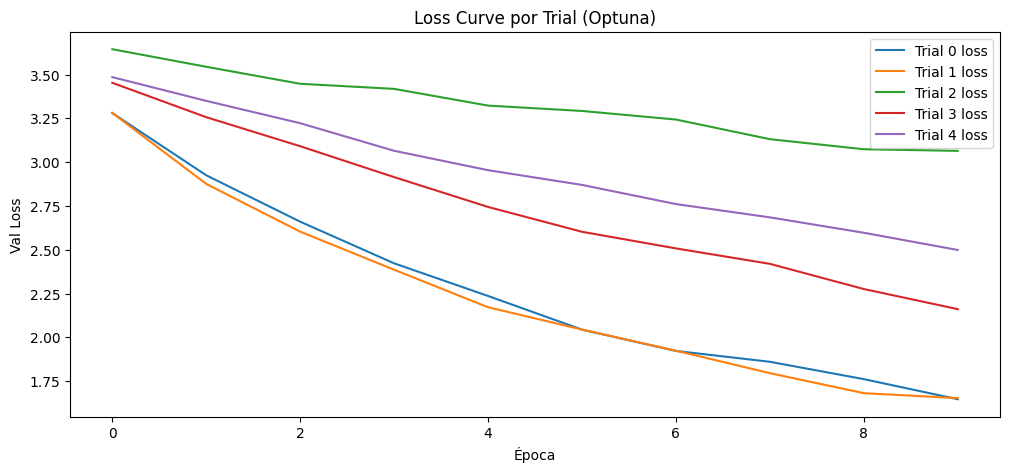

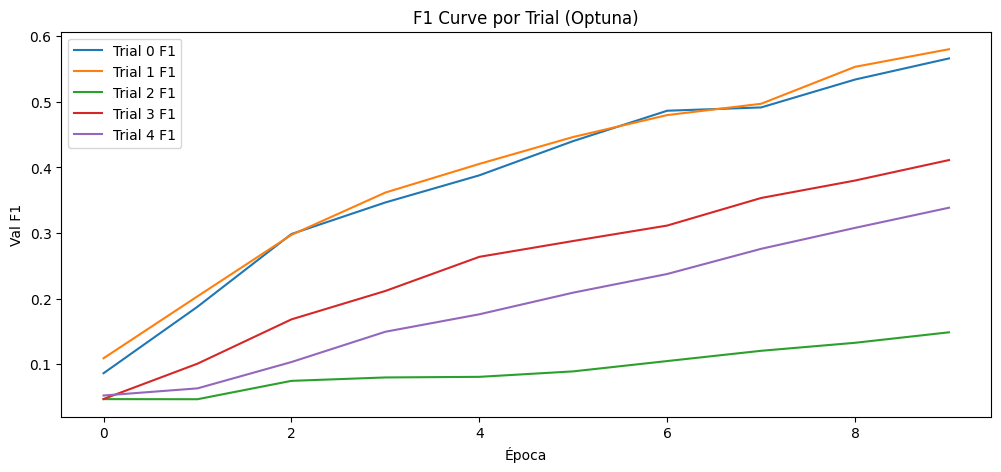

In [8]:
#split estratificado do train em train+val.
from sklearn.model_selection import StratifiedShuffleSplit

# separa validação estratificada a partir do train_dataset (recomendado)
labels = np.array([s[1] for s in train_dataset.samples])
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, val_idx = next(sss.split(np.zeros(len(labels)), labels))

# Subset samplers/datasets
from torch.utils.data import Subset
train_subset = Subset(train_dataset, train_idx)
val_subset   = Subset(train_dataset, val_idx)

train_loader_search = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader_search   = DataLoader(val_subset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Dicionário para guardar histórico de cada trial
trial_histories = {}

# --- função run_training atualizada ---
def run_training(model, train_loader, val_loader, device, lr=1e-4, weight_decay=1e-4, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    best_val_f1 = 0.0
    best_state = None

    # histórico
    history = {"train_loss": [], "val_loss": [], "val_f1": []}

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_preds, val_targets = evaluate(model, val_loader, criterion, device)
        val_f1 = f1_score(val_targets, val_preds, average='macro')

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_f1"].append(val_f1)

        print(f"Epoch {epoch+1}/{epochs} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_f1={val_f1:.4f}")
        scheduler.step(val_loss)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_val_f1, history


# --- função objetivo para Optuna ---
def objective(trial):
    model_name = trial.suggest_categorical("model_name", ["tf_efficientnet_b0", "tf_efficientnet_b3", "tf_efficientnet_b4"])
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
    epochs = 10  # busca rápida

    # cria modelo pré-treinado
    model = create_model(model_name, num_classes=num_classes, pretrained=True).to(device)

    # --- congela todas as camadas, exceto o classificador ---
    for param in model.parameters():
        param.requires_grad = False
    for param in model.get_classifier().parameters():  # timm usa get_classifier()
        param.requires_grad = True

    # treina apenas o classificador
    model, best_val_f1, history = run_training(model, train_loader_search, val_loader_search, device, lr, weight_decay, epochs)

    trial_histories[trial.number] = history
    return best_val_f1


# --- Execução da busca de hiperparâmetros ---
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=5)  # aumente para resultados mais sólidos

print("Melhor trial:", study.best_trial.params, "Melhor F1:", study.best_value)


# --- Gráficos da busca de hiperparâmetros ---
plt.figure(figsize=(12,5))
for i, hist in trial_histories.items():
    plt.plot(hist['val_loss'], label=f'Trial {i} loss')
plt.title("Loss Curve por Trial (Optuna)")
plt.xlabel("Época")
plt.ylabel("Val Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
for i, hist in trial_histories.items():
    plt.plot(hist['val_f1'], label=f'Trial {i} F1')
plt.title("F1 Curve por Trial (Optuna)")
plt.xlabel("Época")
plt.ylabel("Val F1")
plt.legend()
plt.show()


Epoch 1/30 | train_loss=3.4087 | val_loss=3.0695 | val_f1=0.1618


Epoch 2/30 | train_loss=2.8741 | val_loss=2.6289 | val_f1=0.2890


Epoch 3/30 | train_loss=2.4994 | val_loss=2.2804 | val_f1=0.3886


Epoch 4/30 | train_loss=2.2158 | val_loss=2.0661 | val_f1=0.4599


Epoch 5/30 | train_loss=2.0001 | val_loss=1.8399 | val_f1=0.5139


Epoch 6/30 | train_loss=1.8278 | val_loss=1.6937 | val_f1=0.5530


Epoch 7/30 | train_loss=1.7051 | val_loss=1.5862 | val_f1=0.5833


Epoch 8/30 | train_loss=1.5811 | val_loss=1.4895 | val_f1=0.6063


Epoch 9/30 | train_loss=1.4971 | val_loss=1.3858 | val_f1=0.6373


Epoch 10/30 | train_loss=1.4421 | val_loss=1.3783 | val_f1=0.6356


Epoch 11/30 | train_loss=1.3789 | val_loss=1.3072 | val_f1=0.6560


Epoch 12/30 | train_loss=1.3388 | val_loss=1.2418 | val_f1=0.6724


Epoch 13/30 | train_loss=1.2571 | val_loss=1.2016 | val_f1=0.6773


Epoch 14/30 | train_loss=1.2510 | val_loss=1.1491 | val_f1=0.6879


Epoch 15/30 | train_loss=1.2072 | val_loss=1.1400 | val_f1=0.6929


Epoch 16/30 | train_loss=1.1700 | val_loss=1.0857 | val_f1=0.7134


Epoch 17/30 | train_loss=1.1588 | val_loss=1.0604 | val_f1=0.7107


Epoch 18/30 | train_loss=1.1168 | val_loss=1.0442 | val_f1=0.7148


Epoch 19/30 | train_loss=1.1113 | val_loss=1.0051 | val_f1=0.7227


Epoch 20/30 | train_loss=1.0559 | val_loss=0.9864 | val_f1=0.7275


Epoch 21/30 | train_loss=1.0496 | val_loss=0.9973 | val_f1=0.7261


Epoch 22/30 | train_loss=1.0000 | val_loss=0.9870 | val_f1=0.7300


Epoch 23/30 | train_loss=1.0119 | val_loss=0.9783 | val_f1=0.7267


Epoch 24/30 | train_loss=1.0034 | val_loss=0.9109 | val_f1=0.7515


Epoch 25/30 | train_loss=0.9770 | val_loss=0.8900 | val_f1=0.7448


Epoch 26/30 | train_loss=0.9725 | val_loss=0.8908 | val_f1=0.7462


Epoch 27/30 | train_loss=0.9493 | val_loss=0.8987 | val_f1=0.7464


Epoch 28/30 | train_loss=0.9342 | val_loss=0.8823 | val_f1=0.7478


Epoch 29/30 | train_loss=0.9325 | val_loss=0.8691 | val_f1=0.7560


Epoch 30/30 | train_loss=0.9127 | val_loss=0.8602 | val_f1=0.7574
Melhor F1 (val): 0.7573948012495383


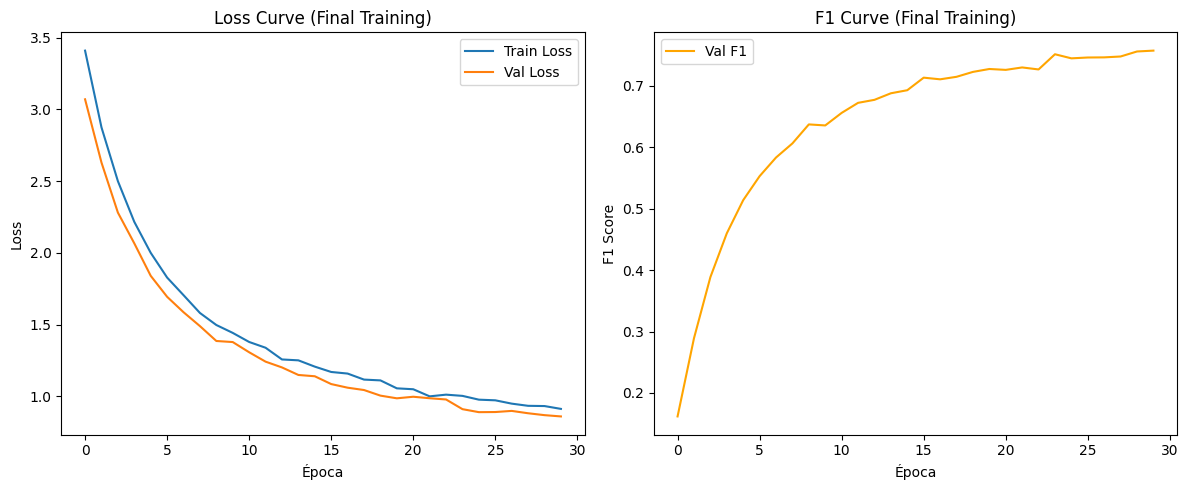

In [9]:
best_params = study.best_trial.params
best_model_name = best_params.get("model_name", "tf_efficientnet_b3")
best_lr = best_params.get("lr", 1e-4)
best_wd = best_params.get("weight_decay", 1e-4)

final_model = create_model(best_model_name, num_classes=num_classes, pretrained=True).to(device)
EPOCHS_FINAL = 30

final_model, best_val_f1, history = run_training(final_model, train_loader, test_loader, device, lr=best_lr, weight_decay=best_wd, epochs=EPOCHS_FINAL)
print("Melhor F1 (val):", best_val_f1)

# --- Gráficos finais ---
fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs[0].plot(history['train_loss'], label='Train Loss')
axs[0].plot(history['val_loss'], label='Val Loss')
axs[0].set_title('Loss Curve (Final Training)')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(history['val_f1'], label='Val F1', color='orange')
axs[1].set_title('F1 Curve (Final Training)')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('F1 Score')
axs[1].legend()

plt.tight_layout()
plt.show()


Test loss: 0.8601957293103139
Test acc: 0.76125
Test F1 macro: 0.7573948012495383
                   precision    recall  f1-score   support

          Airport     0.6835    0.6750    0.6792        80
         BareLand     0.9375    0.7500    0.8333        80
    BaseballField     0.9114    0.9000    0.9057        80
            Beach     0.8701    0.8375    0.8535        80
           Bridge     0.6825    0.5375    0.6014        80
           Center     0.6167    0.4625    0.5286        80
           Church     0.7349    0.7625    0.7485        80
       Commercial     0.7065    0.8125    0.7558        80
 DenseResidential     0.6792    0.9000    0.7742        80
           Desert     0.8810    0.9250    0.9024        80
         Farmland     0.9080    0.9875    0.9461        80
           Forest     0.8462    0.9625    0.9006        80
       Industrial     0.5670    0.6875    0.6215        80
           Meadow     0.9275    0.8000    0.8591        80
MediumResidential     0.8226    

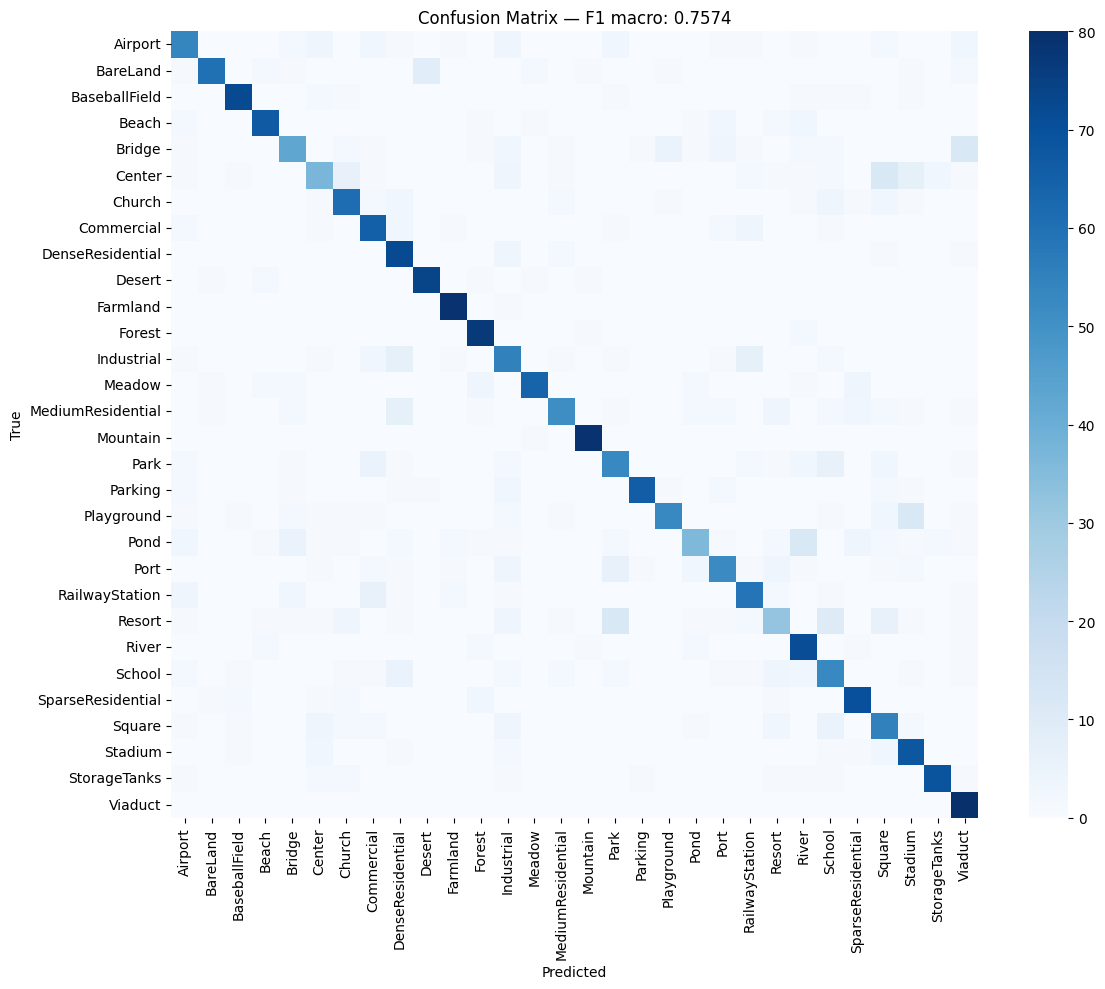

In [10]:
# Cel 9
criterion = nn.CrossEntropyLoss()
test_loss, test_acc, preds, targets = evaluate(final_model, test_loader, criterion, device)

macro_f1 = f1_score(targets, preds, average='macro')
print("Test loss:", test_loss)
print("Test acc:", test_acc)
print("Test F1 macro:", macro_f1)

report = classification_report(targets, preds, target_names=test_dataset.classes, digits=4)
print(report)

cm = confusion_matrix(targets, preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — F1 macro: {macro_f1:.4f}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(test_dataset.classes))+0.5, labels=test_dataset.classes, rotation=90)
plt.yticks(ticks=np.arange(len(test_dataset.classes))+0.5, labels=test_dataset.classes, rotation=0)
plt.tight_layout()
plt.show()
